<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/convolutional_neural_networks/cnn_image_classifier_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 REQUIRED LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# 🔧 Loading and Transforming the CIFAR-10 Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB channels
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

classes = train_set.classes

100%|██████████| 170M/170M [00:03<00:00, 48.2MB/s]


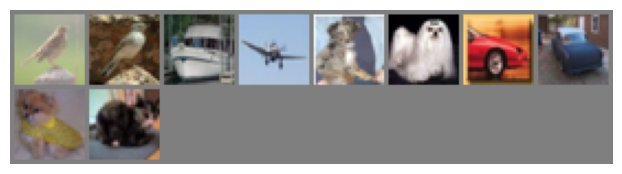

bird  bird  ship  airplane dog   dog   automobile automobile dog   cat  


In [3]:
# 🔍 Display some sample images

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 10 images from the batch
imshow(make_grid(images[:10]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

In [4]:
# 🧠 Simple CNN Architecture

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (32, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (64, 8, 8)
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)            # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier().to(device)
print(f"Model will run on: {device}")

Model will run on: cuda


In [6]:
# 🔧 Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 🔁 Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate on test data
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

In [8]:
# 🚀 Start Training
train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10)

Epoch 1/10, Loss: 1.3459, Test Accuracy: 62.08%
Epoch 2/10, Loss: 0.9806, Test Accuracy: 69.01%
Epoch 3/10, Loss: 0.8265, Test Accuracy: 72.01%
Epoch 4/10, Loss: 0.7186, Test Accuracy: 72.05%
Epoch 5/10, Loss: 0.6291, Test Accuracy: 73.61%
Epoch 6/10, Loss: 0.5436, Test Accuracy: 74.20%
Epoch 7/10, Loss: 0.4764, Test Accuracy: 73.85%
Epoch 8/10, Loss: 0.4139, Test Accuracy: 74.17%
Epoch 9/10, Loss: 0.3678, Test Accuracy: 74.70%
Epoch 10/10, Loss: 0.3278, Test Accuracy: 74.98%


Text(0.5, 0, 'Epoch')

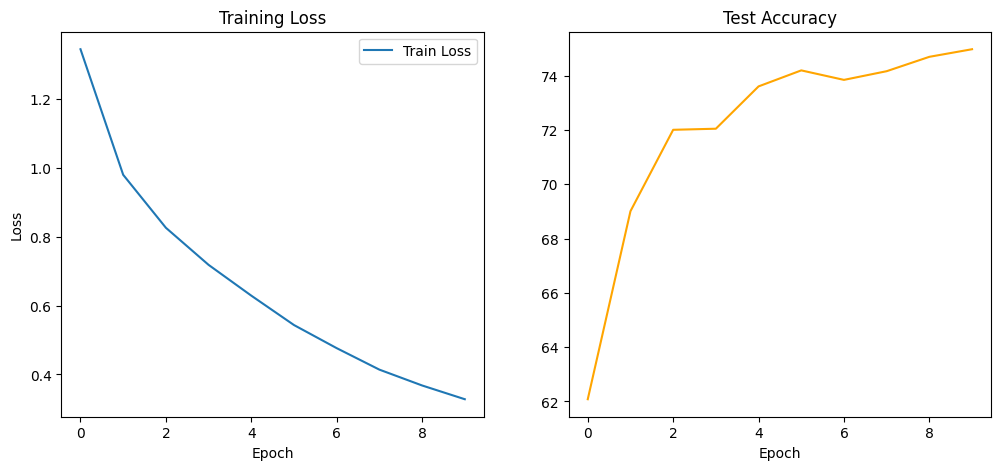

In [9]:
# 📊 Loss and Accuracy Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='orange')
plt.title("Test Accuracy")
plt.xlabel("Epoch")

In [10]:
# 🧪 Make predictions on the test set and evaluate
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 🧾 Classification Report
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.76      0.82      0.79      1000
  automobile       0.86      0.83      0.85      1000
        bird       0.66      0.65      0.66      1000
         cat       0.58      0.56      0.57      1000
        deer       0.74      0.69      0.71      1000
         dog       0.66      0.64      0.65      1000
        frog       0.77      0.82      0.80      1000
       horse       0.80      0.82      0.81      1000
        ship       0.88      0.82      0.85      1000
       truck       0.78      0.84      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



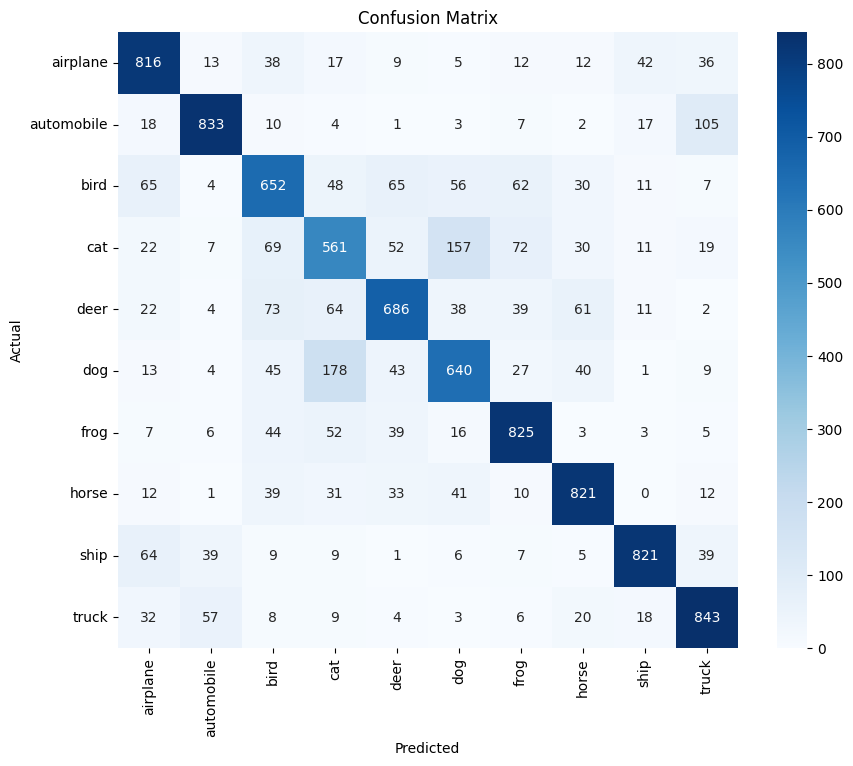

In [11]:
# 🔁 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

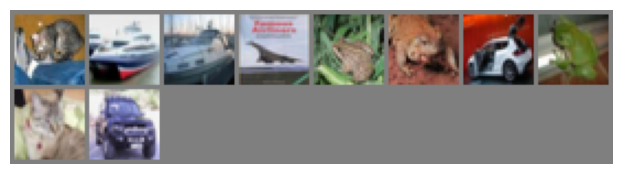

Actual Labels    :  cat | ship | ship | airplane | frog | frog | automobile | frog | cat | automobile
Predicted Labels :  cat | ship | ship | airplane | cat | frog | automobile | frog | cat | automobile


In [12]:
# 🎯 Display predictions for 10 random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images[:10].to(device), labels[:10].to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

imshow(make_grid(images))
print("Actual Labels    : ", ' | '.join(classes[label] for label in labels))
print("Predicted Labels : ", ' | '.join(classes[pred] for pred in preds))